In [13]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble.forest import _generate_unsampled_indices
from sklearn.ensemble.forest import _generate_sample_indices

from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

from tqdm import tqdm_notebook as tqdm

from joblib import Parallel, delayed
import pickle

In [35]:
def generate_2d_rotation(theta=0, acorn=None):
    if acorn is not None:
        np.random.seed(acorn)
    
    R = np.array([
        [np.cos(theta), np.sin(theta)],
        [-np.sin(theta), np.cos(theta)]
    ])
    
    return R

def generate_parity(n, d=2, angle_params=None, acorn=None):
    if acorn is not None:
        np.random.seed(acorn)
        
    X = np.random.uniform(-2, 2, size=(10*n, d))
    Y = (np.sum(X > 0, axis=1) % 2 == 0).astype(int)
    
    if d == 2:
        if angle_params is None:
            angle_params = np.random.uniform(0, 2*np.pi)
        R = generate_2d_rotation(angle_params)
        X = X @ R
        inds = (abs(X[:, 0]) < 1) + (abs(X[:, 1]) < 1)
        Y = Y[(abs(X[:, 0]) < 1) * (abs(X[:, 1]) < 1)][:n]
        X = X[(abs(X[:, 0]) < 1) * (abs(X[:, 1]) < 1)][:n]
    return X, Y.astype(int)

def generate_gaussian_parity(n, mean=np.array([-1, -1]), cov_scale=1, angle_params=None, k=1, acorn=None):
    if acorn is not None:
        np.random.seed(acorn)
        
    d = len(mean)
    
    if mean[0] == -1 and mean[1] == -1:
        mean = mean + 1 / 2**k
    
    mnt = np.random.multinomial(n, 1/(4**k) * np.ones(4**k))
    cumsum = np.cumsum(mnt)
    cumsum = np.concatenate(([0], cumsum))
    
    Y = np.zeros(n)
    X = np.zeros((n, d))
    

    for i in range(2**k):
        for j in range(2**k):
            if cov_scale == 0:
                temp = np.random.uniform(-1, -1 + 1/2**(k-1), size=(mnt[i*(2**k) + j], d))
            else:
                temp = np.random.multivariate_normal(mean, cov_scale * np.eye(d), 
                                                     size=mnt[i*(2**k) + j])
            temp[:, 0] += i*(1/2**(k-1))
            temp[:, 1] += j*(1/2**(k-1))

            X[cumsum[i*(2**k) + j]:cumsum[i*(2**k) + j + 1]] = temp
            
            if i % 2 == j % 2:
                Y[cumsum[i*(2**k) + j]:cumsum[i*(2**k) + j + 1]] = 0
            else:
                Y[cumsum[i*(2**k) + j]:cumsum[i*(2**k) + j + 1]] = 1
                
    if d == 2:
        if angle_params is None:
            angle_params = np.random.uniform(0, 2*np.pi)
        
        R = generate_2d_rotation(angle_params)
        X = X @ R
        
#         Y = Y[(abs(X[:, 0]) < 1) * (abs(X[:, 1]) < 1)][:n]
#         X = X[(abs(X[:, 0]) < 1) * (abs(X[:, 1]) < 1)][:n]
    else:
        raise ValueError('d=%i not implemented!'%(d))
       
    return X[:n], Y.astype(int)[:n]

def get_colors(colors, inds):
    c = [colors[i] for i in inds]
    return c

In [164]:
def estimate_posteriors(tree, X, y):
    n = X.shape[0]
    size = len(np.unique(y))

#     def worker(tree):
        # Count the occurences of each class in each leaf node,
        # by first extracting the leaves.
        # node_counts = tree.tree_.n_node_samples
    unique_leaf_nodes = get_leaves(tree)

    class_counts_per_leaf = np.zeros(
        (len(unique_leaf_nodes), size)
    )

    # Drop each estimation example down the tree, and record its 'y' value.
    for i in range(len(y)):
        temp_node = tree.apply(X[i].reshape((1, -1))).item()
        class_counts_per_leaf[
            np.where(unique_leaf_nodes == temp_node)[0][0], y[i]
        ] += 1

    # Count the number of data points in each leaf in.
    n_per_leaf = class_counts_per_leaf.sum(axis=1)
    n_per_leaf[n_per_leaf == 0] = 1  # Avoid divide by zero.

    # Posterior probability distributions in each leaf.
    # Each row is length num_classes.
    posterior_per_leaf = np.divide(
        class_counts_per_leaf,
        np.repeat(n_per_leaf.reshape((-1, 1)), size, axis=1),
    )
    posterior_per_leaf = finite_sample_correction(
        posterior_per_leaf, n_per_leaf
    )
    posterior_per_leaf = posterior_per_leaf.tolist()


#         return (posterior_per_leaf, tree, unique_leaf_nodes)

#     if parallel:
#         uncertainty_per_tree = Parallel(n_jobs=-2)(
#             delayed(worker)(idx_tree) for idx_tree in enumerate(forest)
#         )
#     else:
#         uncertainty_per_tree = []
#         for idx_tree in enumerate(forest):
#             uncertainty_per_tree.append(worker(idx_tree))

#     posterior_info = []
#     for elem in uncertainty_per_tree:
#         posterior_info.append(elem[0:3])

    return posterior_per_leaf, tree, unique_leaf_nodes


def predict(posterior_info, X):
    
    eval_posteriors = np.zeros((X.shape[0], len(posterior_info[0][0][0])))
    
    for i, p_info in enumerate(posterior_info):
        posterior_per_leaf = p_info[0]
        tree = p_info[1]
        unique_leaf_nodes = p_info[2]
        
            # Posterior probability for each element of the evaluation set.
        eval_posteriors += np.array(
            [
            posterior_per_leaf[np.where(unique_leaf_nodes == node)[0][0]]
            for node in tree.apply(X)
            ]
        )

    return np.argmax(eval_posteriors, axis=1)


def get_leaves(estimator):
    """
    Internal function to get leaf node ids of estimator.

    Input
    estimator: a fit DecisionTreeClassifier

    Return
    leaf_ids: numpy array; an array of leaf node ids

    Usage
    _estimate_posteriors(..)
    """

    # adapted from https://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html
    n_nodes = estimator.tree_.node_count
    children_left = estimator.tree_.children_left
    children_right = estimator.tree_.children_right
    feature = estimator.tree_.feature
    threshold = estimator.tree_.threshold

    leaf_ids = []
    stack = [(0, -1)] 
    while len(stack) > 0:
        node_id, parent_depth = stack.pop()

        # If we have a test node
        if (children_left[node_id] != children_right[node_id]):
            stack.append((children_left[node_id], parent_depth + 1))
            stack.append((children_right[node_id], parent_depth + 1))
        else:
            leaf_ids.append(node_id)

    return np.array(leaf_ids)
    
    
def finite_sample_correction(class_probs, row_sums):
    """
    An internal function for finite sample correction of posterior estimation.

    Input
    class_probs: numpy array; array of posteriors to correct
    row_sums: numpy array; array of partition counts

    Output
    class_probs: numpy array; finite sample corrected posteriors

    Usage
    _estimate_posteriors(..)

    """

    where_0 = np.argwhere(class_probs == 0)
    for elem in where_0:
        class_probs[elem[0], elem[1]] = 1 / (2 * row_sums[elem[0], None])
    where_1 = np.argwhere(class_probs == 1)
    for elem in where_1:
        class_probs[elem[0], elem[1]] = 1 - 1 / (2 * row_sums[elem[0], None])

    return class_probs

In [165]:
def task_similarity_estimation_experiment(nx, funcx, paramsx, classifierx, classifier_paramsx,
                                          nz, funcz, paramsz, classifierz, classifier_paramsz,
                                          T=1,
                                          acorn=None):
    
    if acorn is None:
        np.random.seed(acorn)
                
    T = T
#     Tz = 10

    # Target task
    X, y = funcx(nx, *paramsx)

    # Source task
    Z, w = funcz(nz, *paramsz)
    
    task1_forest = []
    task2_forest = []
    
    for t in range(T):
        bag_idx = np.random.choice(nx, int(0.67*nx), replace=True)
        
        task1_tree = classifierx(**classifier_paramsx)
        task1_tree.fit(X[bag_idx], y[bag_idx])
        task1_forest.append(task1_tree)
        
        task2_tree = classifierz(**classifier_paramsz)
        task2_tree.fit(Z[bag_idx], w[bag_idx])
        task2_forest.append(task2_tree)
        
    task1_posteriors = []
    task2_posteriors = []
    for t in range(T):
        task1_posteriors.append(estimate_posteriors(task1_forest[t], X, y))
        task2_posteriors.append(estimate_posteriors(task2_forest[t], X, y))
        
    yhat1 = predict(task1_posteriors, X)
    yhat2 = predict(task2_posteriors, X)
        
        
        
#     task1_posteriors = estimate_posteriors(task1_posteriors, X, y)
#     yhat1 = predict(task1_posteriors, X) 
    
    
        
        
    
#     shuffle = np.random.choice(nx, nx, replace=False)

#     # 60 / 20 / 20
#     transform_idx = shuffle[:int(0.6*nx)]

#     not_transform_idx = shuffle[int(0.6*nx):]
#     vote_idx = shuffle[int(0.6*nx): int(0.8*nx)]
#     valid_idx = shuffle[:nx - int(0.8*nx)]

#     task1_tree = classifierx(**classifier_paramsx)
#     task1_tree.fit(X, y)
#     task1_posteriors = estimate_posteriors(task1_tree, X, y)
#     yhat1 = predict(task1_posteriors, X) 



#     task2_posteriors = estimate_posteriors(task2_tree, X, y)
#     yhat2 = predict(task2_posteriors, X)
    
    return np.mean(yhat1 == yhat2)

In [169]:
dists = {'XOR': {
                'funcx':generate_gaussian_parity, 
                'paramsx': (np.array([-1, -1]), 0.1, 0, 1),
                'classifierx': DecisionTreeClassifier,
                'classifier_paramsx': {},
                },
         'N-XOR':{'funcx':generate_gaussian_parity, 
                'paramsx': (np.array([-1, -1]), 0.1, np.pi/2, 1),
                'classifierx': DecisionTreeClassifier,
                'classifier_paramsx': {},
                },
             
         'R-XOR':{'funcx':generate_gaussian_parity, 
                'paramsx': (np.array([-1, -1]), 0.1, np.pi/4, 1),
                'classifierx': DecisionTreeClassifier,
                'classifier_paramsx': {},
                },
         'F-XOR':{'funcx':generate_gaussian_parity, 
                'paramsx': (np.array([-1, -1]), 0.01, 0, 2),
                'classifierx': DecisionTreeClassifier,
                'classifier_paramsx': {},
                },
        }

In [181]:
acorn=1
np.random.seed(acorn)

ns = np.array([20, 50, 100, 200, 500, 1000, 2000, 5000, 10000])
# ns = np.array([100, 5000])
means = np.zeros((len(dists), len(dists), len(ns)))
std_errors = np.zeros((len(dists), len(dists), len(ns)))

n_mc=30
for i, n in enumerate(tqdm(ns)):
    for j, key1 in enumerate(dists):
        temp = np.zeros(n_mc)

        for k, key2 in enumerate(dists):
            condensed_func = lambda x : task_similarity_estimation_experiment(x, 
                                                                              dists[key1]['funcx'],
                                                                              dists[key1]['paramsx'],
                                                                              dists[key1]['classifierx'],
                                                                              dists[key1]['classifier_paramsx'],
                                                                              n,
                                                                              dists[key2]['funcx'],
                                                                              dists[key2]['paramsx'],
                                                                              dists[key2]['classifierx'],
                                                                              dists[key2]['classifier_paramsx'],
                                                                              T=10
                                                                            )
                                                                              
            temp = np.array(Parallel(n_jobs=-2)(delayed(condensed_func)(int(x)) for x in n*np.ones(n_mc)))
            
            means[j,k,i] = np.mean(temp)
            std_errors[j,k,i] = np.std(temp) / np.sqrt(n_mc)

In [183]:
pickle.dump(means, open('means_estimated_task_similarity_defaults_maxn_%i_acorn%i'%(ns[-1], acorn), 'wb'))
pickle.dump(std_errors, open('std_errors_estimated_task_similarity_defaults_maxn%u_acorn%i'%(ns[-1], acorn), 'wb'))

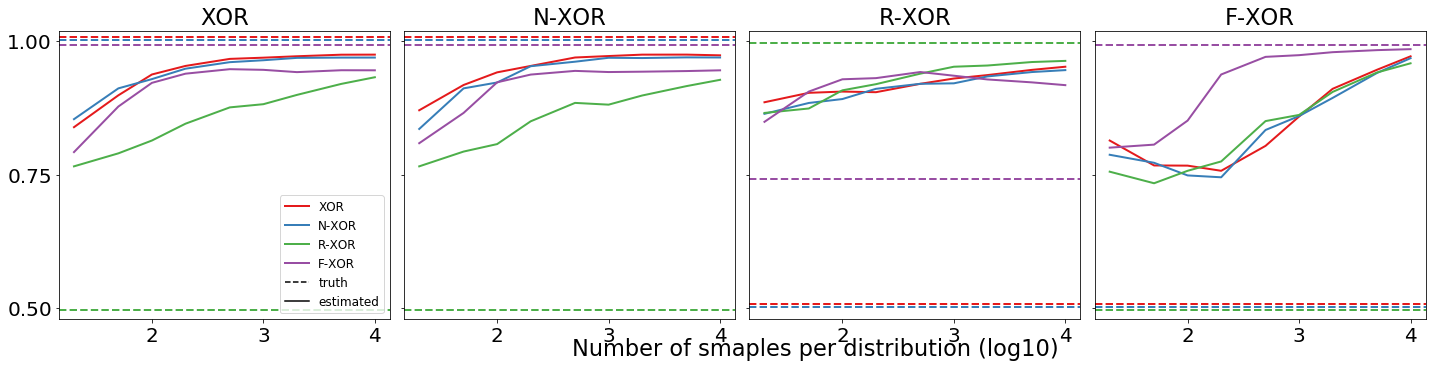

In [212]:
# means = pickle.load(open('means_estimated_task_similarity_defaults_acorn%i'%(acorn), 'rb'))
# std_errors = pickle.load(open('std_errors_estimated_task_similarity_defaults_acorn%i'%(acorn), 'rb'))
np.random.seed(1)

# ns = np.array([20, 50, 100, 200, 500, 1000, 2000, 5000, 10000])
colors = sns.color_palette('Set1', n_colors=4)

truth = np.array([
    [1, 1, 0.5, 1],
    [1, 1, 0.5, 1],
    [0.5, 0.5, 1, 0.75],
    [0.5, 0.5, 0.5, 1],
])

jiggles = np.array([0.0075, 0.0025, -0.0025, -0.0075])

fig, ax = plt.subplots(1,4,figsize=(20,5), sharey=True, sharex=True)
fig.text(0.4, 0, 'Number of smaples per distribution (log10)', fontsize=fontsize) #.set_xlabel('Number of samples per distribution (log10)')

fontsize=22.5
labelsize=20

for i, key1 in enumerate(dists):
    ax[i].set_title(key1, fontsize=fontsize)
#     ax[i].set_xlabel('Number of samples per distribution (log10)', fontsize=fontsize)
    ax[i].set_ylim(0.48, 1.02)
    ax[i].set_yticks([0.5, 0.75, 1])
    ax[i].tick_params(labelsize=20)
    for j, key2 in enumerate(dists):
        ax[i].plot(np.log10(ns), means[i,j]+jiggles[j], label=key2, c=colors[j], lw=2)
        ax[i].axhline(y=truth[i,j]+jiggles[j], ls='--', c=colors[j], lw=2)
    ax[i].axhline(y=0, c='k', ls='--', label='truth')
    ax[i].axhline(y=0, c='k', label='estimated')
    if i == 0:
        ax[i].legend(loc='lower right', fontsize=12)
        
plt.tight_layout()
plt.savefig('figures/task-dissimilarity-2/estimated_task_similarity_10trees_defaults.pdf')

array([[[0.825     , 0.90066667, 0.93666667, 0.94533333, 0.95666667,
         0.96336667, 0.96565   ],
        [0.83833333, 0.898     , 0.93      , 0.95316667, 0.95626667,
         0.96383333, 0.96553333],
        [0.80333333, 0.778     , 0.813     , 0.85533333, 0.86933333,
         0.87386667, 0.905     ],
        [0.84      , 0.89333333, 0.92866667, 0.94466667, 0.9498    ,
         0.95316667, 0.95211667]],

       [[0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        ]],

       [[0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,


In [302]:
X, y = generate_gaussian_parity(1000, cov_scale=0.1, angle_params=0)
dt = DecisionTreeClassifier(max_depth=3, criterion='gini')
dt.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

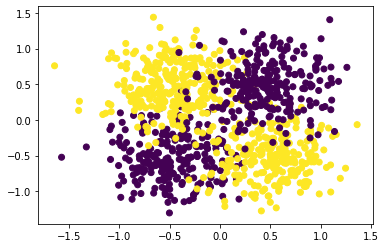

In [303]:
fig, ax = plt.subplots(1,1)
ax.scatter(X[:, 0], X[:, 1], c=y)

[Text(167.4, 190.26, 'X[0] <= 0.499\ngini = 0.5\nsamples = 1000\nvalue = [486, 514]'),
 Text(83.7, 135.9, 'X[1] <= -0.197\ngini = 0.5\nsamples = 753\nvalue = [379, 374]'),
 Text(41.85, 81.53999999999999, 'X[0] <= 0.029\ngini = 0.422\nsamples = 288\nvalue = [201, 87]'),
 Text(20.925, 27.180000000000007, 'gini = 0.143\nsamples = 207\nvalue = [191, 16]'),
 Text(62.775000000000006, 27.180000000000007, 'gini = 0.216\nsamples = 81\nvalue = [10, 71]'),
 Text(125.55000000000001, 81.53999999999999, 'X[0] <= 0.004\ngini = 0.473\nsamples = 465\nvalue = [178, 287]'),
 Text(104.625, 27.180000000000007, 'gini = 0.252\nsamples = 298\nvalue = [44, 254]'),
 Text(146.475, 27.180000000000007, 'gini = 0.317\nsamples = 167\nvalue = [134, 33]'),
 Text(251.10000000000002, 135.9, 'X[1] <= 0.043\ngini = 0.491\nsamples = 247\nvalue = [107, 140]'),
 Text(209.25, 81.53999999999999, 'X[1] <= -0.325\ngini = 0.138\nsamples = 148\nvalue = [11, 137]'),
 Text(188.32500000000002, 27.180000000000007, 'gini = 0.0\nsamples

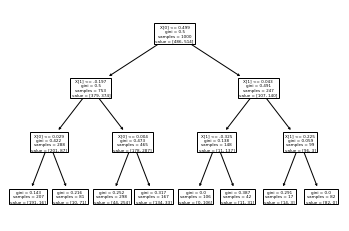

In [304]:
from sklearn import tree
tree.plot_tree(dt)

In [317]:
max_depth=2

dists_md = {'XOR': {
                'funcx':generate_gaussian_parity, 
                'paramsx': (np.array([-1, -1]), 0.1, 0, 1),
                'classifierx': DecisionTreeClassifier,
                'classifier_paramsx': {'max_depth': max_depth},
                },
         'N-XOR':{'funcx':generate_gaussian_parity, 
                'paramsx': (np.array([-1, -1]), 0.1, np.pi/2, 1),
                'classifierx': DecisionTreeClassifier,
                'classifier_paramsx': {'max_depth': max_depth},
                },
             
         'R-XOR':{'funcx':generate_gaussian_parity, 
                'paramsx': (np.array([-1, -1]), 0.1, np.pi/4, 1),
                'classifierx': DecisionTreeClassifier,
                'classifier_paramsx': {'max_depth': max_depth},
                },
         'F-XOR':{'funcx':generate_gaussian_parity, 
                'paramsx': (np.array([-1, -1]), 0.01, 0, 2),
                'classifierx': DecisionTreeClassifier,
                'classifier_paramsx': {'max_depth': max_depth+3},
                },
        }

In [322]:
acorn=1
np.random.seed(acorn)

ns = np.array([20, 50, 100, 200, 500, 1000, 2000, 5000, 10000])
means = np.zeros((len(dists), len(dists), len(ns)))
std_errors = np.zeros((len(dists), len(dists), len(ns)))

n_mc=100
for i, n in enumerate(tqdm(ns)):
    for j, key1 in enumerate(dists_md):
        temp = np.zeros(n_mc)

        for k, key2 in enumerate(dists_md):
            condensed_func = lambda x : task_similarity_estimation_experiment(x, 
                                                                              dists_md[key1]['funcx'],
                                                                              dists_md[key1]['paramsx'],
                                                                              dists_md[key1]['classifierx'],
                                                                              dists_md[key1]['classifier_paramsx'],
                                                                              n,
                                                                              dists_md[key2]['funcx'],
                                                                              dists_md[key2]['paramsx'],
                                                                              dists_md[key2]['classifierx'],
                                                                              dists_md[key2]['classifier_paramsx']
                                                                            )
                                                                              
            temp = np.array(Parallel(n_jobs=-2)(delayed(condensed_func)(int(x)) for x in n*np.ones(n_mc)))
            
            means[j,k,i] = np.mean(temp)
            std_errors[j,k,i] = np.std(temp) / np.sqrt(n_mc)

In [323]:
pickle.dump(means, open('means_estimated_task_similarity_maxdepth%i_maxn_%i_acorn%i'%(max_depth, ns[-1], acorn), 'wb'))
pickle.dump(std_errors, open('std_errors_estimated_task_similarity_maxdepth%i_maxn%i_acorn%i'%(max_depth, ns[-1], acorn), 'wb'))

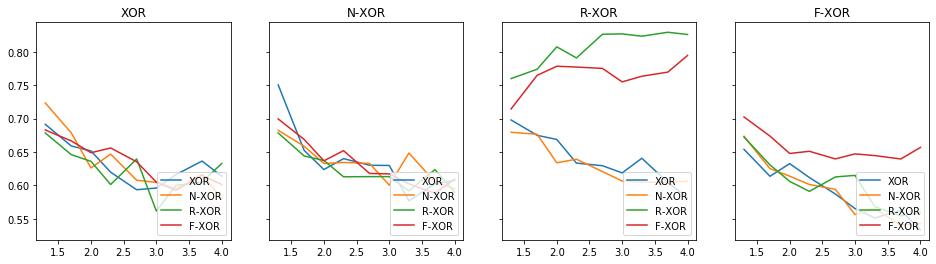

In [324]:
# means = pickle.load(open('means_estimated_task_similarity_maxdepth2_maxn_%i_acorn%i'%(ns[-1], acorn), 'rb'))
# std_errors = pickle.load(open('std_errors_estimated_task_similarity_maxdepth2_maxn%i_acorn%i'%(ns[-1], acorn), 'rb'))

# ns = np.array([20, 50, 100, 200, 500, 1000, 2000, 5000, 10000])
fig, ax = plt.subplots(1,4,figsize=(16,4), sharey=True)

for i, key1 in enumerate(dists_md):
    ax[i].set_title(key1)
    for j, key2 in enumerate(dists_md):
        ax[i].plot(np.log10(ns), means[i,j], label=key2)
    ax[i].legend(loc='lower right')

In [333]:
max_depth=3

dists_md = {'XOR': {
                'funcx':generate_gaussian_parity, 
                'paramsx': (np.array([-1, -1]), 0.1, 0, 1),
                'classifierx': DecisionTreeClassifier,
                'classifier_paramsx': {'max_depth': max_depth},
                },
         'N-XOR':{'funcx':generate_gaussian_parity, 
                'paramsx': (np.array([-1, -1]), 0.1, np.pi/2, 1),
                'classifierx': DecisionTreeClassifier,
                'classifier_paramsx': {'max_depth': max_depth},
                },
             
         'R-XOR':{'funcx':generate_gaussian_parity, 
                'paramsx': (np.array([-1, -1]), 0.1, np.pi/4, 1),
                'classifierx': DecisionTreeClassifier,
                'classifier_paramsx': {'max_depth': max_depth},
                },
         'F-XOR':{'funcx':generate_gaussian_parity, 
                'paramsx': (np.array([-1, -1]), 0.01, 0, 2),
                'classifierx': DecisionTreeClassifier,
                'classifier_paramsx': {'max_depth': max_depth+3},
                },
        }

In [334]:
acorn=1
np.random.seed(acorn)

ns = np.array([20, 50, 100, 200, 500, 1000, 2000, 5000, 10000])
means = np.zeros((len(dists), len(dists), len(ns)))
std_errors = np.zeros((len(dists), len(dists), len(ns)))

n_mc=100
for i, n in enumerate(tqdm(ns)):
    for j, key1 in enumerate(dists_md):
        temp = np.zeros(n_mc)

        for k, key2 in enumerate(dists_md):
            condensed_func = lambda x : task_similarity_estimation_experiment(x, 
                                                                              dists_md[key1]['funcx'],
                                                                              dists_md[key1]['paramsx'],
                                                                              dists_md[key1]['classifierx'],
                                                                              dists_md[key1]['classifier_paramsx'],
                                                                              n,
                                                                              dists_md[key2]['funcx'],
                                                                              dists_md[key2]['paramsx'],
                                                                              dists_md[key2]['classifierx'],
                                                                              dists_md[key2]['classifier_paramsx']
                                                                            )
                                                                              
            temp = np.array(Parallel(n_jobs=-2)(delayed(condensed_func)(int(x)) for x in n*np.ones(n_mc)))
            
            means[j,k,i] = np.mean(temp)
            std_errors[j,k,i] = np.std(temp) / np.sqrt(n_mc)

In [335]:
pickle.dump(means, open('means_estimated_task_similarity_maxdepth%i_maxn_%i_acorn%i'%(max_depth, ns[-1], acorn), 'wb'))
pickle.dump(std_errors, open('std_errors_estimated_task_similarity_maxdepth%i_maxn%i_acorn%i'%(max_depth, ns[-1], acorn), 'wb'))

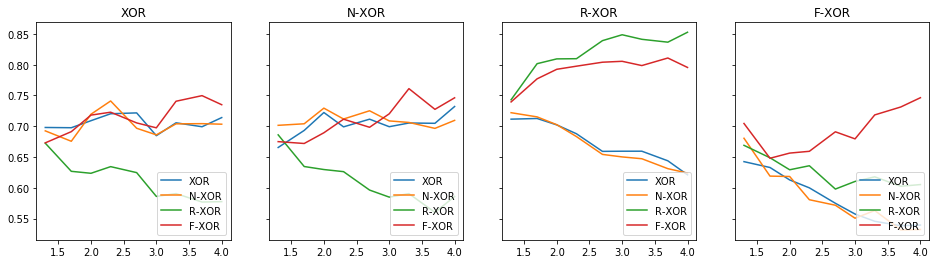

In [336]:
fig, ax = plt.subplots(1,4,figsize=(16,4), sharey=True)

for i, key1 in enumerate(dists_md):
    ax[i].set_title(key1)
    for j, key2 in enumerate(dists_md):
        ax[i].plot(np.log10(ns), means[i,j], label=key2)
    ax[i].legend(loc='lower right')